In [1]:
import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

import sklearn
import xgboost as xgb
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error 

In [2]:
%matplotlib inline

# Data

## Read data

In [3]:
main_path = 'D:/Resumes and Internships/Tests/Decathlon'

In [4]:
def get_path(path, extension='csv'):
    """
    Get absolute or relative path for file
    """
    output_path = os.path.join(main_path, path + '.' + extension)
    if not os.path.exists(output_path):
        output_path = os.path.join('.', path + '.' + extension)
    
    return output_path

In [5]:
df_train = pd.read_csv(get_path('data/train'))
df_test  = pd.read_csv(get_path('data/test'))
df_feat  = pd.read_csv(get_path('data/bu_feat'))

## Exploring data

In [6]:
df_train.head(10)

,day_id,but_num_business_unit,dpt_num_department,turnover
0,2017-09-30,64,127,580.308443
1,2017-09-30,119,127,1512.995918
2,2017-09-30,4,88,668.593556
3,2017-09-30,425,127,0.000000
4,2017-09-30,513,73,0.000000
5,2017-09-30,211,88,271.276864
6,2017-09-30,10,117,21.436326
7,2017-09-30,177,88,193.990051
8,2017-09-30,39,73,265.385406
9,2017-09-30,214,88,718.790912


In [7]:
df_test.head(10)

,day_id,but_num_business_unit,dpt_num_department
0,2017-11-25,95,73
1,2017-11-25,4,117
2,2017-11-25,113,127
3,2017-11-25,93,117
4,2017-11-25,66,127
5,2017-11-25,225,88
6,2017-11-25,37,117
7,2017-11-25,720,73
8,2017-11-25,1015,127
9,2017-11-25,505,88


In [8]:
df_feat.head(10)

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
0,1609,80100,50.096306,1.867220,69,4
1,1995,95700,48.991087,2.520903,3,6
2,1800,73210,45.552933,6.644736,51,4
3,238,47550,44.175370,0.638869,134,10
4,201,13546,43.508418,5.406423,71,10
5,242,72610,48.404324,0.087680,72,6
6,541,73100,45.718899,5.923290,51,4
7,95,80000,49.869382,2.280452,69,4
8,74,49071,47.467695,-0.619092,72,6
9,119,74100,46.195037,6.254448,51,4


In [9]:
df_train.describe()

,but_num_business_unit,dpt_num_department,turnover
count,277719.000000,277719.000000,277719.000000
mean,294.199464,101.288832,561.818472
std,291.664511,21.667318,2113.229765
min,1.000000,73.000000,-69.791165
25%,81.000000,88.000000,11.785140
50%,204.000000,88.000000,232.724186
75%,427.000000,127.000000,676.655825
max,1887.000000,127.000000,1000000.000000


In [10]:
df_test.describe()

,but_num_business_unit,dpt_num_department
count,10136.000000,10136.000000
mean,414.886346,101.207577
std,445.932616,21.679104
min,1.000000,73.000000
25%,95.000000,88.000000
50%,237.000000,88.000000
75%,549.000000,117.000000
max,1887.000000,127.000000


In [11]:
df_feat.describe()

,but_num_business_unit,but_postcode,but_latitude,but_longitude,but_region_idr_region,zod_idr_zone_dgr
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,435.162577,51203.460123,47.002270,2.637551,63.199387,12.202454
std,474.138722,26716.870578,2.333283,2.786303,47.901374,18.605263
min,1.000000,1100.000000,41.954300,-4.436446,2.000000,1.000000
25%,97.250000,31000.000000,44.959619,0.707571,31.000000,4.000000
50%,242.500000,56050.000000,47.373887,2.598707,64.000000,6.000000
75%,553.750000,74575.000000,48.885216,4.904543,74.000000,10.000000
max,1995.000000,98000.000000,51.050275,8.796100,178.000000,72.000000


In [12]:
print("Number of rows with NaN values in train table   : ", len(df_train[df_train.isnull().any(axis=1)]))
print("Number of rows with NaN values in test table    : ", len(df_test[df_test.isnull().any(axis=1)]))
print("Number of rows with NaN values in features table: ", len(df_feat[df_feat.isnull().any(axis=1)]))

Number of rows with NaN values in train table   :  0
Number of rows with NaN values in test table    :  0
Number of rows with NaN values in features table:  0


The definition of outliers is tricky here as the stores and deps have different scales of sales, However, the aim here is to resolve extreme values so rather than picking **3**, i.e. the datapoints that sit between -3 and 3 times the std over the mean, I'll take **7**.

In [13]:
mean = df_train['turnover'].mean()
std = df_train['turnover'].std()

print("The number of extreme outliers in the data is :", len(df_train.loc[np.abs(df_train['turnover'] - mean >= (7 * std)), :]))
df_train = df_train.loc[np.abs(df_train['turnover'] - mean < (7 * std)), :]

The number of extreme outliers in the data is : 14


### Limit data for training

In [14]:
limit_row = 322*4*52*5
df_train.loc[:, 'day_id'] = pd.to_datetime(df_train['day_id'])
df_train = df_train.sort_values(by='day_id').iloc[:limit_row,:]

## Preprocess data

In [15]:
def process_date_col(df):
    """
    Create date related columns from the date
    """
    df = df.copy()
    df.loc[:, "date"] = pd.to_datetime(df["day_id"])
    df.loc[:, "year"] = df["date"].dt.year
    df.loc[:, "month"] = df["date"].dt.month
    df.loc[:, 'woy'] = df["date"].dt.week
    return df

In [16]:
columns_mapping = {
                  "but_num_business_unit" : "bun",
                  "dpt_num_department"    : "dep",
                  "but_postcode"          : "zip",
                  "but_latitude"          : "lat",
                  "but_longitude"         : "lon",
                  "but_region_idr_region" : "reg",
                  "zod_idr_zone_dgr"      : "zod"
                 }

In [17]:
# Roughly
mapping = {'winter': [49,50,51,52] + list(range(0,9)),
           'spring': list(range(9,22)),
           'summer': list(range(22,35)),
           'autumn': list(range(35,49))}

mapping = {i: season for i in range(53) for season in mapping.keys() if i in mapping[season]}

In [18]:
df_train = process_date_col(df_train).rename(columns = columns_mapping, inplace = False)
df_test = process_date_col(df_test).rename(columns = columns_mapping, inplace = False)
df_feat = df_feat.rename(columns = columns_mapping, inplace = False)

In [19]:
df_train = df_train.merge(df_feat, on='bun', how='left').sort_values(by=['year', 'month', 'bun', 'dep']).reset_index()
df_test  = df_test.merge(df_feat, on='bun', how='left').sort_values(by=['year', 'month', 'bun', 'dep']).reset_index()

In [20]:
df_train.loc[:, 'sea'] = df_train['woy'].map(mapping)
df_test.loc[:, 'sea'] =  df_test['woy'].map(mapping)

In [21]:
features = ['year', 'month', 'woy', 'bun', 'dep', 'sea', 'lat', 'lon', 'reg', 'zod']
target = ['turnover']

In [22]:
df_train = df_train[features + target]
df_test = df_test[features]

## Prep questions 1 - 2  - 3 

In [23]:
result = df_train.loc[df_train['year']==2016, ['dep', 'turnover']].groupby(['dep']).sum().sort_values(by='turnover', ascending=False)

In [24]:
index = list(result.index)
print("The department that had the highest turnover during 2016 is : ",  index if index else [] )

The department that had the highest turnover during 2016 is :  [127, 117, 88, 73]


In [25]:
result = df_train.loc[df_train['dep']==88, ['woy', 'turnover']].groupby(['woy']).sum().sort_values(by='turnover', ascending=False).head(5)

In [26]:
print("The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are : ", list(result.index))

The top 5 week numbers for department 88 in 2015 in terms of turnover over all stores are :  [37, 36, 38, 27, 2]


In [27]:
result = df_train.loc[df_train['year']==2014, ['bun', 'turnover']].groupby(['bun']).sum().sort_values(by='turnover', ascending=False)

In [28]:
index = list(result.index)
print("The top performer store in 2014 is : ", index if index else [])

The top performer store in 2014 is :  [121, 17, 118, 189, 100, 11, 51, 10, 19, 39, 292, 32, 62, 122, 67, 5, 232, 539, 225, 132, 175, 505, 90, 52, 28, 27, 70, 119, 30, 288, 4, 243, 73, 81, 26, 82, 429, 18, 129, 308, 95, 83, 444, 198, 78, 468, 53, 214, 13, 76, 48, 40, 162, 22, 89, 42, 55, 23, 216, 338, 36, 454, 167, 66, 188, 405, 69, 54, 41, 61, 127, 88, 252, 8, 353, 152, 92, 694, 239, 553, 136, 25, 403, 116, 37, 483, 58, 60, 97, 110, 35, 200, 80, 63, 231, 134, 93, 255, 279, 426, 204, 16, 31, 6, 178, 155, 74, 456, 139, 148, 241, 156, 133, 186, 84, 158, 498, 267, 212, 296, 219, 151, 522, 125, 12, 640, 282, 79, 77, 834, 34, 131, 14, 113, 163, 691, 1, 818, 253, 191, 33, 99, 210, 450, 233, 297, 289, 49, 9, 195, 482, 427, 344, 254, 183, 724, 159, 201, 2, 381, 115, 24, 184, 298, 64, 117, 765, 20, 249, 179, 199, 408, 237, 345, 363, 238, 336, 29, 221, 641, 57, 275, 154, 72, 348, 236, 652, 65, 541, 96, 349, 302, 50, 71, 227, 692, 554, 211, 193, 658, 177, 98, 242, 753, 180, 549, 149, 45, 773, 15, 

## Plots

### Correlation

In [29]:
plot_cor = False # Requires a lot of compute

if plot_cor:
    _ = pd.plotting.scatter_matrix(df_train, figsize=(15,15), diagonal='kde')

### Total turnover per different levels

#### Per year and week

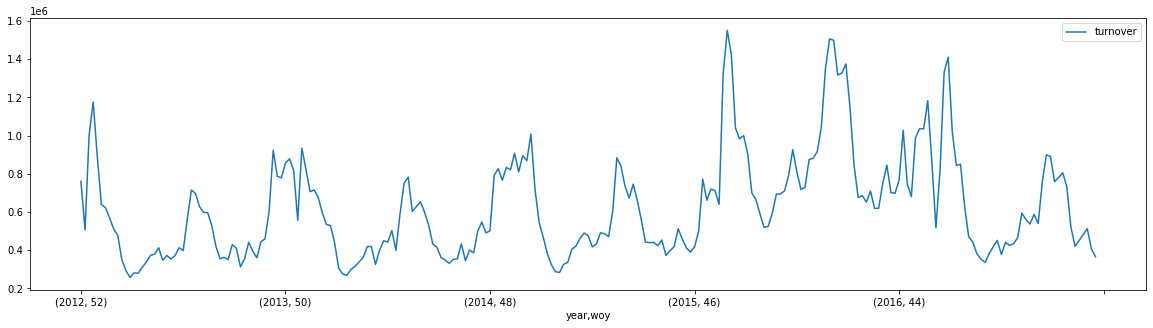

In [30]:
df_train[['year', 'woy', 'turnover']].groupby(['year', 'woy']).sum().plot(y='turnover', figsize=(20,5))

#### Per department

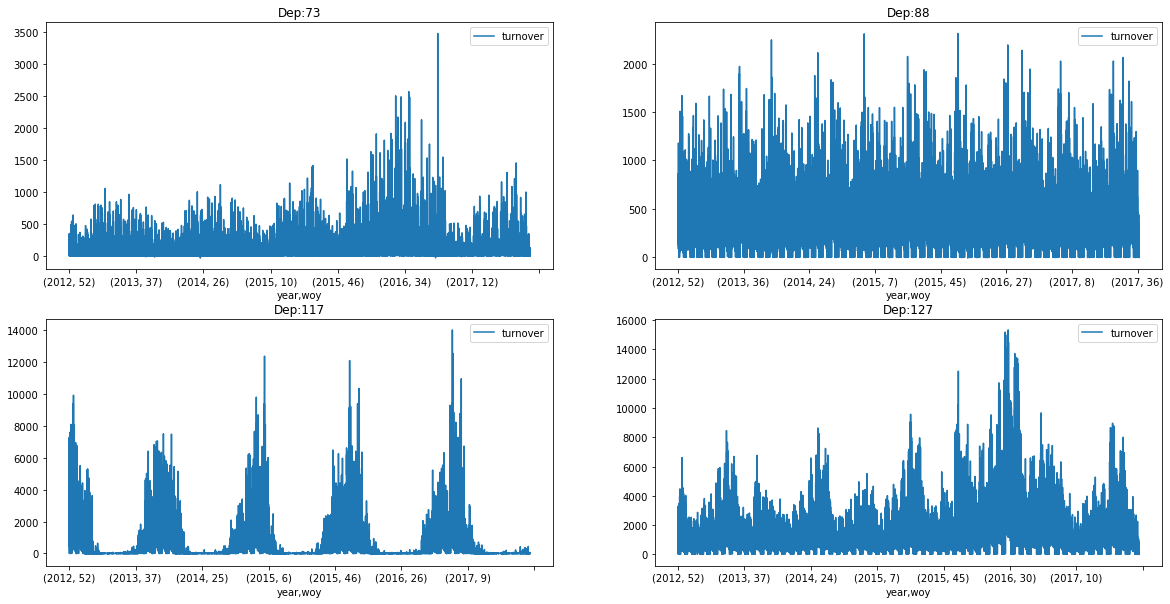

In [31]:
counter = 0
n_rows, n_cols = 2, 2
deps = df_train['dep'].unique()
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20,10))

for row in range(n_rows):
    for col in range(n_cols):
        ax = axes[row,col]
        sample = df_train.loc[df_train['dep']==deps[counter],:].copy().set_index(['year', 'woy'])
        sample.plot(y='turnover', ax=ax)
        ax.set_title(f'Dep:{deps[counter]}')
        counter += 1

## Prep questions: 4 - 5

In [32]:
years = list(df_train['year'].unique())

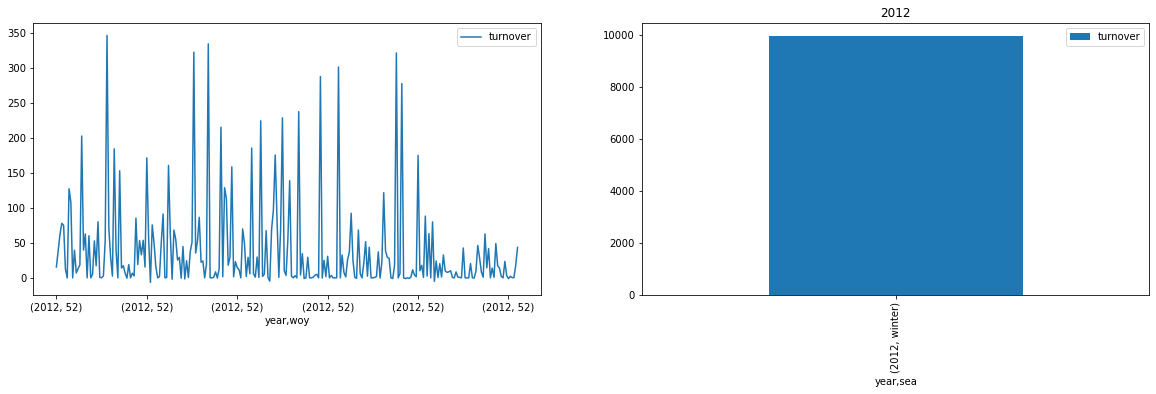

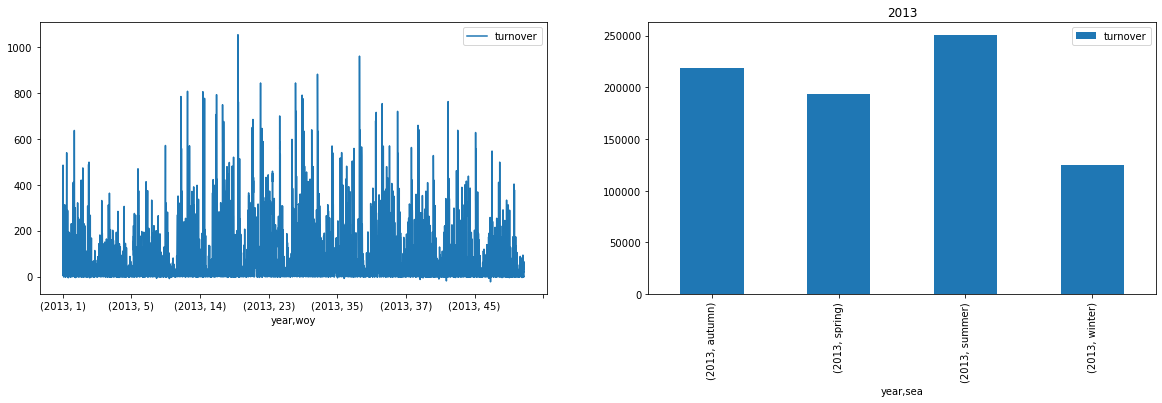

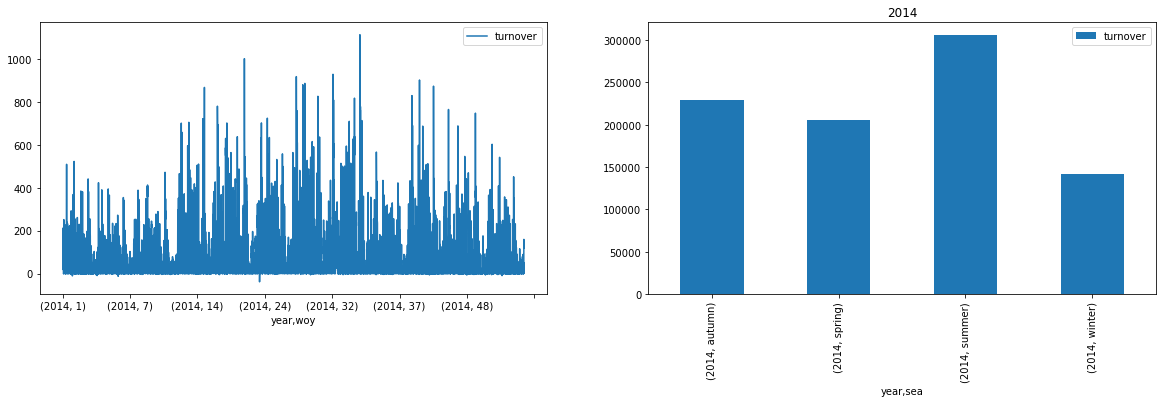

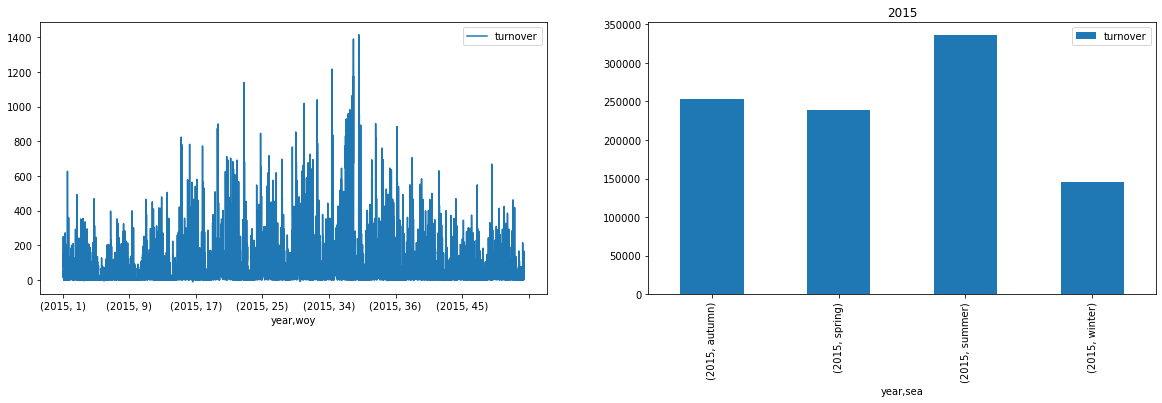

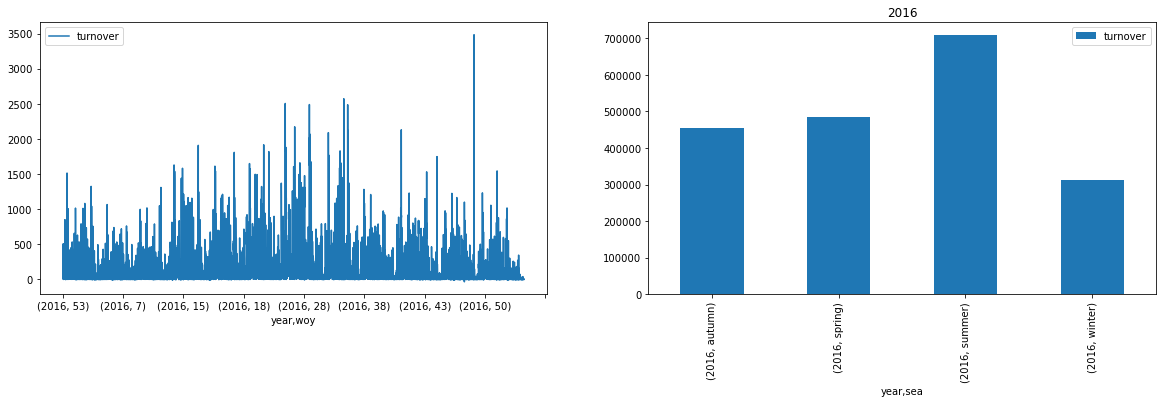

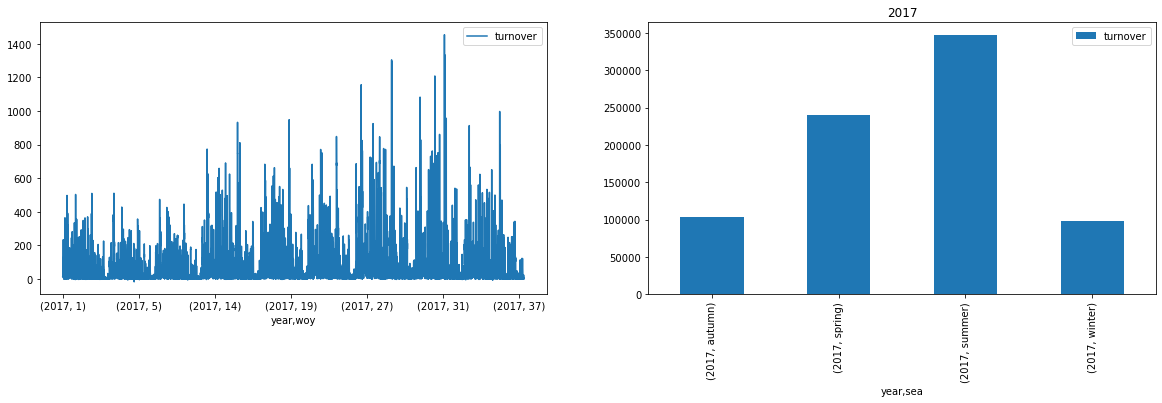

In [33]:
for year in years:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sample_1 = df_train.loc[(df_train['dep']==73)&(df_train['year']==year), :].set_index(['year', 'woy'])
    sample_2 = df_train.loc[(df_train['dep']==73)&(df_train['year']==year), :].groupby(['year', 'sea']).sum()
    sample_1.plot(ax=axes[0], y='turnover')
    sample_2.plot(ax=axes[1], y='turnover', kind='bar')
    plt.title(f'{year}')

From the plots above, it seems that the department 73 has a slightly higher values during spring and summer, however, isn't enough to conclude that the sport is a summer-only one. In order to ver

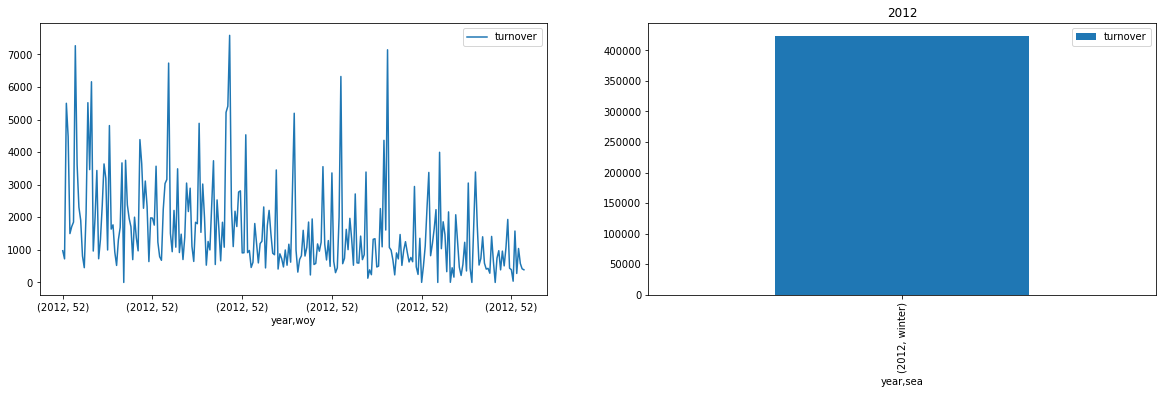

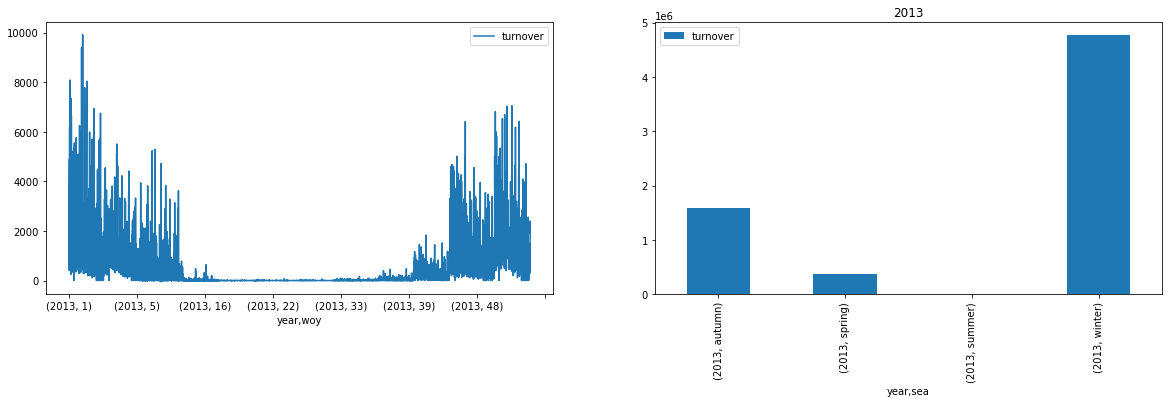

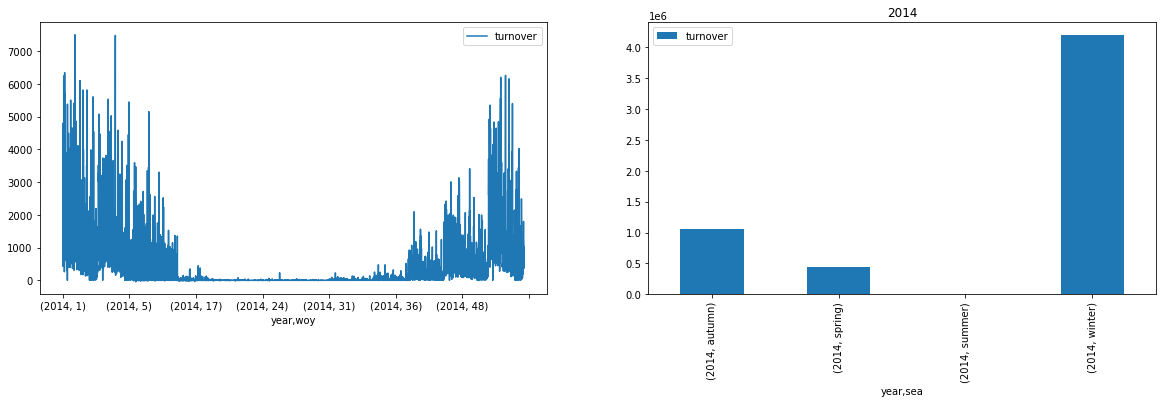

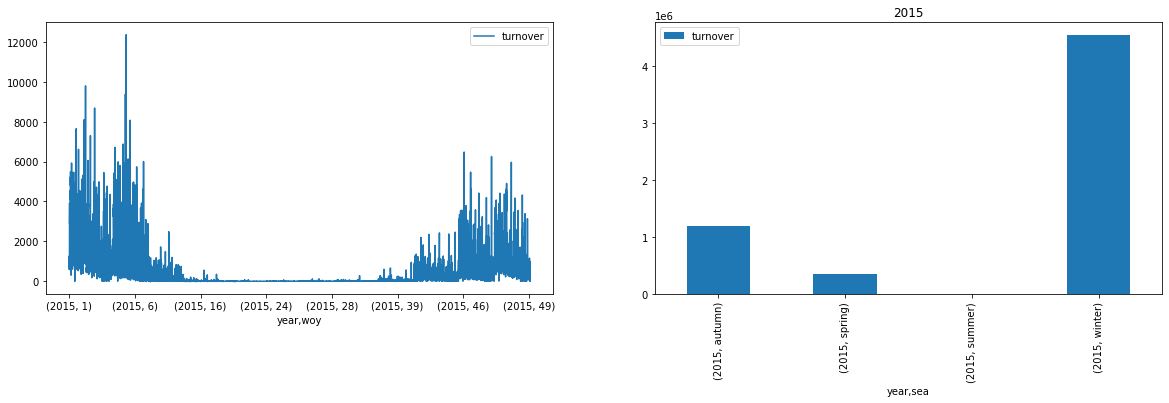

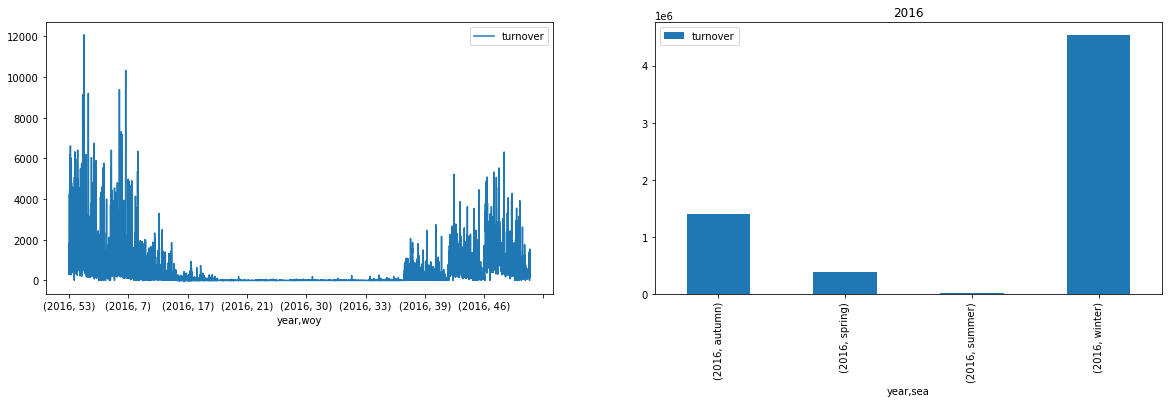

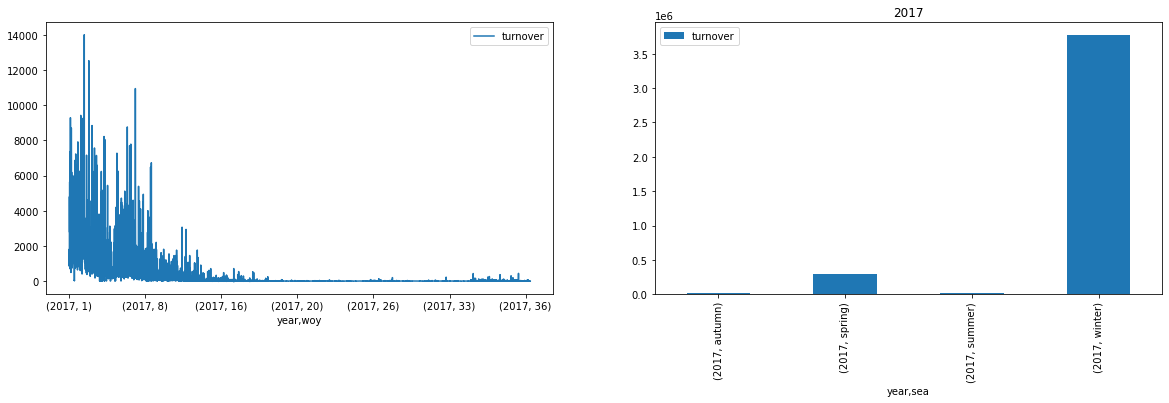

In [34]:
for year in years:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
    sample_1 = df_train.loc[(df_train['dep']==117)&(df_train['year']==year), :].set_index(['year', 'woy'])
    sample_2 = df_train.loc[(df_train['dep']==117)&(df_train['year']==year), :].groupby(['year', 'sea']).sum()
    sample_1.plot(ax=axes[0], y='turnover')
    sample_2.plot(ax=axes[1], y='turnover', kind='bar')
    plt.title(f'{year}')

Unlike the department 73, the data for departement 117 is almost uni-model around December and January, indicating that this department specializes in winter sports (Although the rising amount of sales does not necessarly reflect an interest in the sport rather most likely the growth of the client, it may be that the sport is Ski). 

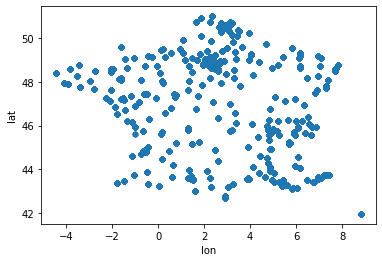

In [35]:
df_train.loc[df_train['dep']==117, ['lon', 'lat']].plot(y='lat', x='lon', kind='scatter')

With no special geographic distribution of the business units in France, we can't go further in the analysis.

#### **Insights**

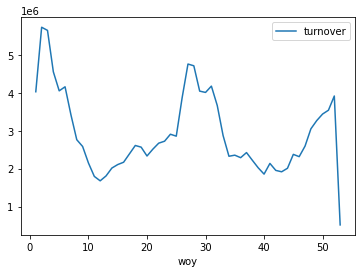

In [36]:
df_train.loc[:, ['woy', 'turnover']].groupby('woy').sum().plot(y='turnover')

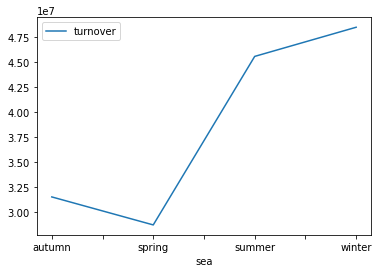

In [37]:
df_train.loc[:, ['sea', 'turnover']].groupby('sea').sum().plot(y='turnover')

The plots hereabove show that the highest amount of sales is due during winter (in average).

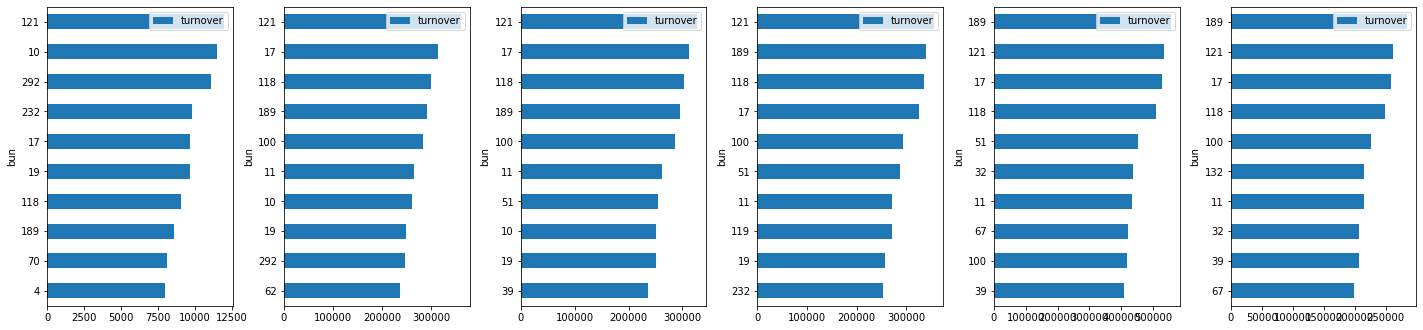

In [67]:
fig, axes = plt.subplots(1, len(years), figsize=(20,5))
plt.tight_layout(pad=2)

for i, year in enumerate(years):
    sample = df_train.loc[df_train['year']==year, ['bun', 'turnover']].groupby('bun').sum().reset_index()
    sample.sort_values(by='turnover').tail(10).plot.barh(x='bun', y='turnover', ax=axes[i])

Since there aren't external sources that will allow us to predict the share of the sales per store, we can't conceive a model that predicts the overall sales per department (which seems to be easier since the curves show a clear seasonality in the data) that we can then partition over the stores

# Models

### Helper functions

In [39]:
#TODO
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Load from file
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
score = pickle_model.score(Xtest, Ytest)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(Xtest)

NameError: name 'pickle' is not defined

## Preprocessing

In [68]:
def onehot_cols(df, columns):
    """
    One hot encoding of dataframe's columns in provided list
    """
    df = df.copy()
    for col in columns:
        tmp_encoded_data = pd.get_dummies(df[col], prefix=col)
        df[tmp_encoded_data.columns] = tmp_encoded_data
        df = df.drop(columns=[col], inplace=False)
    
    return df

In [69]:
df_train_uni = onehot_cols(df_train, ['sea','bun', 'dep', 'reg', 'zod'])
df_train_multi = onehot_cols(df_train, ['sea', 'reg', 'zod'])

## Uni-model approach

### Data

In [70]:
df_train_uni.head(10)

,year,month,woy,lat,lon,turnover,sea_autumn,sea_spring,sea_summer,sea_winter,...,reg_162,reg_178,zod_1,zod_3,zod_4,zod_6,zod_10,zod_35,zod_59,zod_72
0,2012,12,52,50.628060,2.957377,15.552508,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,2012,12,52,50.628060,2.957377,306.927510,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2012,12,52,50.628060,2.957377,972.944128,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,2012,12,52,50.628060,2.957377,665.646079,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,2012,12,52,50.741153,3.134613,38.474503,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
5,2012,12,52,50.741153,3.134613,316.231685,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
6,2012,12,52,50.741153,3.134613,723.618419,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7,2012,12,52,50.741153,3.134613,707.547441,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
8,2012,12,52,43.600994,7.078160,62.361617,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
9,2012,12,52,43.600994,7.078160,465.821136,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


### Preprocessing

In [71]:
features = list(df_train_uni.columns)
features.remove('turnover')

X, y = df_train_uni[features].to_numpy(), df_train_uni['turnover'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Model testing

Visualy, it seems that a time series analysis won't cut it for this approach as there is no seasonality nor is the serie stationary

#### Decision Tree

In [ ]:
# Arguments
criterions = ['mse', 'friedman_mse', 'mae']
splitters = ['best', 'random']
max_depth = 10

# Model
dt_reg = DecisionTreeRegressor(criterion=criterions[2], splitter=splitters[0], max_depth=max_depth) 
dt_reg.fit(X_train, y_train)
print('Score is : ', dt_reg.score(X_val, y_val))

#### Random Forest

In [ ]:
# Arguments
n_estimators = 10
criterions = ['mse', 'friedman_mse', 'mae']
max_depth = 10

# Model
rf_reg = RandomForestRegressor(n_estimators=n_estimators, criterion=criterions[2],  max_depth=max_depth) 
rf_reg.fit(X_train, y_train)
print('Score is : ', rf_reg.score(X_val, y_val))

#### MLP 

In [ ]:
# Params
n_hidden = 2
hidden_layer_sizes = tuple([50 for _ in range(n_hidden)])
solver = 'adam'             # ['sgd', 'adam']
activation = 'relu'         # ['relu', 'logistic', 'identity']
learning_rate = 'adaptive'  # ['constant', 'invscaling', 'adaptive']
learning_rate_init = 0.01   # [0.01, 0.05, 0.1]
max_iter = 300
verbose = False

# Model
mlp_reg = MLPRegressor(
                       hidden_layer_sizes = hidden_layer_sizes,
                       solver = solver,
                       activation = activation,
                       learning_rate = learning_rate,
                       max_iter = max_iter,
                       verbose = verbose,
                       early_stopping = True
                      ) 

mlp_reg.fit(X_train, y_train)
print('Score is : ', mlp_reg.score(X_val, y_val))

In [ ]:
_ = plt.plot(mlp_reg.loss_curve_)

#### Gradient Boosting

In [ ]:
# Params
n_estimators = 20
loss = 'ls'   # ['ls', 'lad', 'huber', 'quantile']
learning_rate = 1.

gb_reg = GradientBoostingRegressor(
                                   n_estimators = n_estimators,
                                   loss = loss,
                                   learning_rate = learning_rate
                                  )

gb_reg.fit(X_train, y_train)
print('Score is : ', gb_reg.score(X_val, y_val))

#### AdaBoost

In [ ]:
# Params
n_estimators = 20
loss = 'square'   #['linear', 'square', 'exponential'] 
learning_rate = 1.

ada_reg = AdaBoostRegressor(
                            n_estimators = n_estimators,
                            loss = loss,
                            learning_rate = learning_rate
                            )

ada_reg.fit(X_train, y_train)
print('Score is : ', ada_reg.score(X_val, y_val))

#### XGBoost

In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
print('Score is : ', xgb_reg.score(X_val, y_val))

### Model scoring

In [ ]:
def get_scores(models, X, y, k=5):
    """
    Returns a DataFrame of two decimal numbers in binary digits.

    Parameters:
            models (dict): dictionary of scikit-Learn models
            k (int): folds for CV

    Returns:
            scores (pd.DataFrame): DataFrame detailing models
    """

    kf = KFold(n_splits=k)
    results = []

    for model in tqdm(models):
        
        # Init all scores
        scores = {
            'Name'     : model,
            'Max_error': 0,
            'Mae'      : 0,
            'Mse'      : 0,
            'MEae'     : 0, 
            'R2'       : 0,
            'Inference': 0
         }
        
        for train_index, val_index in kf.split(X):
            
            X_train_tmp = X[train_index]
            y_train_tmp = y[train_index]
            X_val_tmp = X[val_index]
            y_val_tmp = y[val_index]
            
            # Fitting the model
            models[model].fit(X_train_tmp, y_train_tmp)
            
            # Inference time
            a = time.time()
            y_val_hat = models[model].predict(X_val_tmp)
            b = time.time()

            # Cross validation
            scores['Max_error'] += max_error(y_val_hat, y_val_tmp)
            scores['Mae'      ] += mean_absolute_error(y_val_hat, y_val_tmp)
            scores['Mse'      ] += mean_squared_error(y_val_hat, y_val_tmp)
            scores['MEae'     ] += median_absolute_error(y_val_hat, y_val_tmp)
            scores['R2'       ] += r2_score(y_val_hat, y_val_tmp)
            scores['Inference'] += b-a
               
        mean_scores = {key: value/k if key!='Name' else value for (key,value) in scores.items()}
        results.append(mean_scores)

    return pd.DataFrame(results)    

In [ ]:
models = {
          'Decision Tree'     : dt_reg,
          'Random Forest'     : rf_reg,
          'MLP regressor'     : mlp_reg,
          'Gradient Boosting' : gb_reg,
          'AdaBoost'          : ada_reg,
          'XGBoost'           : xgb_reg
         }

get_scores(models, X, y)

### Model tuning

#### hyper_opt

### Model selection

### Prediction

## Multi-model approach

In [ ]:
df_train_multi.head(10)

In [ ]:
buns = sorted(list(df_train_multi['bun'].unique()))
deps = sorted(list(df_train_multi['dep'].unique()))

columns = df_train_multi.columns
columns = [_ for _ in columns if _ not in ['buns', 'dep']]

dfs = [[]]

for i, bun in enumerate(buns):
    for j, dep in enumerate(deps):
        sample = df_train_multi.loc[(df_train_multi['bun']==bun)&(df_train_multi['dep']==dep), columns].copy(True)
        sample = sample.sort_values(by=['year', 'month'])
        dfs[-1].append(sample)
        
    dfs.append([])

In [ ]:
print("The departements for which we have data are : ", deps, '\n')
print("The business units for which we have data are : ", buns)

In [ ]:
def plot_curves(bu=None, dep=None, n_rows=5, n_cols=3, figsize=(20,10)):
    """
    Plot curves of turnover for the parameters bun and dep in a n_rowsxn_cols grid
    """
    if not (bu is None or dep is None):
        i = buns.index(bu)
        j = deps.index(dep)
        dfs[i][j].set_index(['year', 'woy']).plot(y='turnover')
        plt.title(f'BU:{buns[i]} - Dep:{deps[j]} - {i}/{j}')
        return None
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=figsize)
    plt.tight_layout(pad=4)
    
    for row in range(n_rows):
        for col in range(n_cols):
            ax = axes[row,col]
            i = np.random.randint(len(buns)) if bu  is None else buns.index(bu)
            j = np.random.randint(len(deps)) if dep is None else deps.index(dep)
            sample = dfs[i][j].set_index(['year', 'woy'])
            sample.plot(y='turnover', ax=ax)
            ax.set_title(f'BU:{buns[i]} - Dep:{deps[j]} - {i}/{j}')

In [ ]:
plot_curves(dep=73)

In [ ]:
plot_curves(dep=88)

In [ ]:
plot_curves(dep=117)

In [ ]:
plot_curves(dep=127)

In [ ]:
plot_curves(bu=1)

In [ ]:
plot_curves(bu=16)

### Models

We will be looking for weak models in this approach given than we will have to maintain more than one model

#### Dummy Regressor

In [ ]:
dm_reg = DummyRegressor()

#### Decision Tree

In [ ]:
dt_reg = DecisionTreeRegressor()

#### LightGBM

#### Time series

Since we are aiming for an automated process, I'll start by using Prophet in order to have access to the autu-fit function

### Aggregation of Models

### Model Scoring

### Model tuning

### Prediction